In [2]:
from sklearn.preprocessing import MaxAbsScaler
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn import pipeline
from sklearn.feature_selection import chi2, mutual_info_regression, f_regression, mutual_info_classif, f_classif, SelectFdr
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
#import mglearn
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import pickle
from sklearn.neighbors import KNeighborsClassifier

In [1]:
%matplotlib inline

In [4]:


train_data = pd.read_table('train_data.txt', delimiter='\t')
test_data = pd.read_table('test_data.txt', delimiter='\t')

train_date = [int(str(i)[:8]) for i in train_data['time']]
test_date = [int(str(i)[:8]) for i in test_data['time']]

subset_train = [ i == 20170808 for i in train_date]
subset_test = [ i == 20170809 for i in test_date]

train_data_correct = train_data.loc[subset_train]
test_data_correct = test_data.loc[subset_test]

x_train = train_data_correct.drop(['sample_id', 'label', 'week'], axis=1)
y_train = train_data_correct['label']

x_test = test_data_correct.drop(['sample_id', 'label', 'week'], axis=1)
y_test = test_data_correct['label']

label_encode = LabelEncoder()
stadard_scaler = StandardScaler()
onehot_encode = OneHotEncoder()

In [5]:
data_all = pd.concat([x_train, x_test], axis=0, ignore_index = True)
data_obj = data_all.select_dtypes(include=['object']).copy().\
iloc[:, [ 0,  1,  3,  6,  8,  9, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22]]
data_num = data_all.select_dtypes(include=['int64']).copy()


In [24]:
data_num.shape

(8946606, 7)

In [25]:
max_scale = MaxAbsScaler()
data_num_scaled = max_scale.fit_transform(np.array(data_num).astype(float))
data_num_pd = pd.DataFrame(data_num_scaled, columns=data_num.columns)
#final = pd.concat([data_num_pd, data_obj], axis = 1, ignore_index=True)
#final_dummy = pd.get_dummies(final)
x_train_final = data_num_pd.iloc[:(4500638),:]
x_test_final = data_num_pd.iloc[(4500638):,:]


In [32]:
x_train_final.shape

(4500638, 175)

##### Save

In [27]:
pickle_out = open("x_train_num_maxAbs.pickle","wb")
pickle.dump(x_train_final, pickle_out)
pickle_out.close()

In [29]:
pickle_out = open("x_test_num_maxAbs.pickle","wb")
pickle.dump(x_test_final, pickle_out)
pickle_out.close()

In [9]:
final = pd.concat([data_num_pd, data_obj], axis = 1, ignore_index=True)
final_dummy = pd.get_dummies(final)
x_train_final = final_dummy.iloc[:(4500638),:]
x_test_final = final_dummy.iloc[(4500638):,:]


In [10]:
pickle_out = open("x_train_final_maxAbs_scale.pickle","wb")
pickle.dump(x_train_final, pickle_out)
pickle_out.close()
pickle_out = open("x_test_final_maxAbs_scale.pickle","wb")
pickle.dump(x_test_final, pickle_out)
pickle_out.close()

### Load numeric columns

In [33]:
x_train_final = pickle.load( open( "x_train_num_maxAbs.pickle", "rb" ) )
x_test_final = pickle.load(open("x_test_num_maxAbs.pickle", "rb"))
y_train = pickle.load(open("y_train.pickle", "rb"))
y_test = pickle.load(open("y_test.pickle", "rb"))

In [34]:
x_train_final.shape

(4500638, 7)

In [35]:
US = RandomUnderSampler(return_indices=True)
x_train_final_US, y_train_US, idx_US = US.fit_sample(x_train_final, y_train)

In [36]:
logi_reg = LogisticRegression(solver = 'lbfgs')

In [58]:
model1 = Pipeline([ 
    ('selectK',  SelectKBest(score_func=mutual_info_classif, k=5)),  
    ('rf', RandomForestClassifier())
])



In [59]:
x_train_final.shape

(4500638, 7)

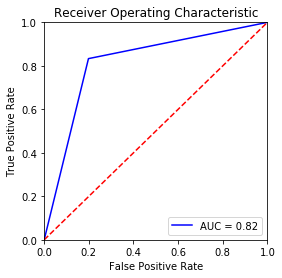

In [60]:
#x_train_final_US = x_train_final.iloc[idx_US,:]
#y_train_US = y_train.iloc[idx_US,:]
model1.fit(x_train_final_US, y_train_US)
y_test_pred = model1.predict(x_test_final)
plt.rcParams["figure.figsize"] = (4,4)

fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
model2 = Pipeline([ 
    ('selectK',  SelectKBest(score_func=mutual_info_classif)),  
    ('rf', RandomForestClassifier())
])


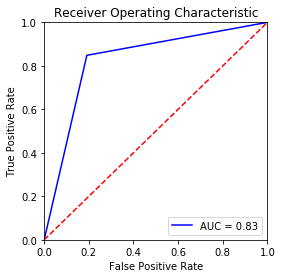

In [20]:
#x_train_final_US = x_train_final.iloc[idx_US,:]
#y_train_US = y_train.iloc[idx_US,:]
model2.fit(x_train_final_US, y_train_US)
y_test_pred = model2.predict(x_test_final)
plt.rcParams["figure.figsize"] = (4,4)

fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [23]:
x_train_final.shape

(4500638, 175)